In [1]:
!pip install transformers sentence_transformers openai swifter umap_learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 42.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.3/55.3 KB 5.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 830.9/830.9 KB 32.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 10.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 67.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 33.8 MB/s eta 0:00:00
   

In [2]:
import pandas as pd
import pyarrow as py
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import openai
openai_api_key = ''

import re

from wordcloud import WordCloud, STOPWORDS

import swifter

import umap.umap_ as umap

from scipy.stats import chi2_contingency
from sklearn.utils import resample

from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split


bert_model = SentenceTransformer('distilbert-base-nli-mean-tokens')

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.99k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/550 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/265M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/450 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

In [3]:
# Connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Import data

path_train = '/content/drive/MyDrive/AtBayHS/df_train.gzip'
path_test = '/content/drive/MyDrive/AtBayHS/df_test.gzip'
train = pd.read_parquet(path_train)
test = pd.read_parquet(path_test)


#Data Integrity

Let s take a look of the datasets train and test to get a first impression.

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1293 entries, 2977 to 6815
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DOMAIN    1293 non-null   object
 1   homepage  1293 non-null   object
dtypes: object(2)
memory usage: 30.3+ KB


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2317 entries, 0 to 2316
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DOMAIN    2317 non-null   object
 1   homepage  2164 non-null   object
 2   label     2317 non-null   object
dtypes: object(3)
memory usage: 54.4+ KB


the train data contains the domain, the homepage of the business. In addition we have the core business as label.

We see that the train set contains 153 missing homepage (6% of the data)

I see two possible asumptions on the model:
1. the model can predict a label even if the homepage text is missing.
2. the model needs the homepage text (thus no empty text also like '')

Because the test data contains homepage for all of its samples, I suppose that the model needs the homepage text.
So I can remove the train sample with missing homepage text.
(The assupmtion 1 can be hadle later)

In [5]:
train.dropna(inplace=True)

# EDA

We first focus on the domain of each website. The assumpation is that after engineering the domain contain some information related to the the label of the website.

Then we focus on the homepage's text. Becaue it come from a website we can assume it contains the information about its content. A specific part of the text explain the label. However the homepage text is also full of garbage text, coming from contacts, links, or disclaimers and others.

## Labels

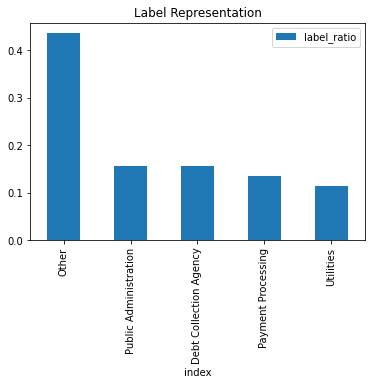

In [ ]:
train.label.value_counts(normalize=True).reset_index(name='label_ratio').plot.bar(x='index',y='label_ratio')
plt.title('Label Representation')
plt.show()

We see clearly that the dataset is imbalanced with too much of label 'Other'.

## Website Domain

First of all we need to understand what does mean internet domains.

From wikipedia (https://en.wikipedia.org/wiki/Domain_name) we can read internet's domain have a top level domain and subs level domain which are located on the left of the top level domain.

The top level domains the most represented in the internet  are: .com - .org - .net 
we can also add .int - .edu - .gov - .mil these ones do not respect the format IDN, so are less common.

We can understand that a domain having these top level listed is better referred in the whole internet. So an unclear website may have a rare top domain hidden in the internet like a streaming website.

In [6]:
train['name_domain'] = train.DOMAIN.apply(lambda d: d.split('.')[0])
train['top_domain'] = train.DOMAIN.apply(lambda d: d.split('.')[-1])
train['is_top_domain'] = train.top_domain.apply(lambda d: d in ['com', 'org','net', 'edu', 'gov', 'mil'])

In [7]:
train.is_top_domain.value_counts(normalize=True)

True     0.929298
False    0.070702
Name: is_top_domain, dtype: float64

The data contains in majority, more than 90%, website with common top level domains.

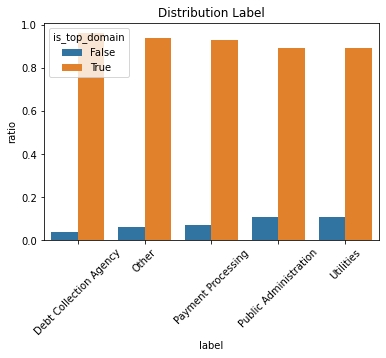

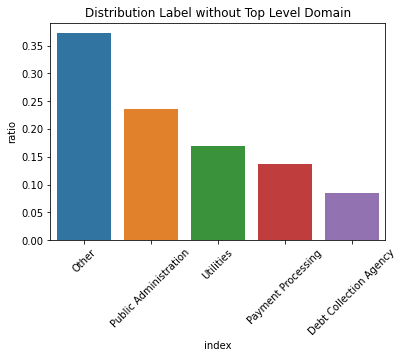

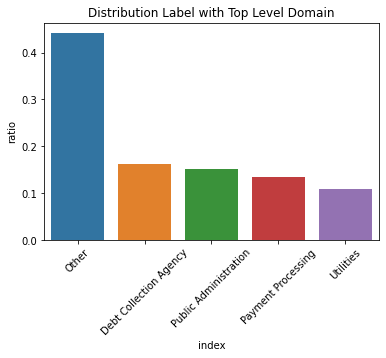

In [8]:
df_label_topd_count = train.groupby('label').is_top_domain.value_counts(normalize=True).reset_index(name='ratio')
sns.barplot(data=df_label_topd_count, x='label', y='ratio', hue='is_top_domain')
plt.xticks(rotation=45)
plt.title('Distribution Label')
plt.show()

df_label_topd_count = train[train.is_top_domain==False].label.value_counts(normalize=True).reset_index(name='ratio')
sns.barplot(data=df_label_topd_count, x='index', y='ratio')
plt.xticks(rotation=45)
plt.title('Distribution Label without Top Level Domain')
plt.show()

df_label_topd_count = train[train.is_top_domain==True].label.value_counts(normalize=True).reset_index(name='ratio')
sns.barplot(data=df_label_topd_count, x='index', y='ratio')
plt.xticks(rotation=45)
plt.title('Distribution Label with Top Level Domain')
plt.show()

I remark that in the group of is_top_domain==False, the order is not the same, it looks like we more likely to obtain 'Public administration' after 'Other' than 'Debt Collection Agency' in the other group.

I want to verify if the variables 'is_top_domain' and 'label' come from the same distribution.
It refers to the dependency test Chi2. But we have an imbalanced representation, so I am using bootstraps to generate more test and get a result.

Original p-value:  0.0012351657519113714
Bootstrap p-value:  0.924


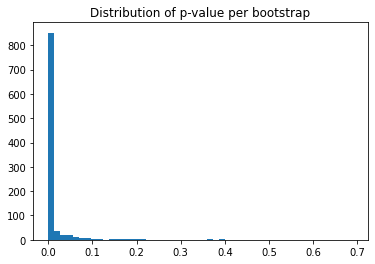

In [ ]:
# original data
df = pd.pivot_table(data=train, index='label', columns='is_top_domain', aggfunc='size').fillna(0)
data = np.array([df[False].values.tolist(),df[True].values.tolist()])

# number of bootstrap samples
n_samples = 1000

# p-value threshold
alpha = 0.05

# calculate test statistic and p-value for original data
_, pval, _, _ = chi2_contingency(data)

# initialize counter for number of times p-value is less than threshold
count = 0
ps = []
# perform bootstrap
for i in range(n_samples):
    # generate bootstrap sample
    
    train_bs = resample(train)
    df_bs = pd.pivot_table(data=train_bs, index='label', columns='is_top_domain', aggfunc='size').fillna(0)
    data_bs = np.array([df_bs[False].values.tolist(),df_bs[True].values.tolist()])

    # calculate test statistic and p-value for bootstrap sample
    _, pval_bs, _, _ = chi2_contingency(data_bs)
    # check if p-value is less than threshold
    if pval_bs < alpha:
        count += 1
    ps.append(pval_bs)
# calculate bootstrap p-value
pval_bs = count / n_samples

print("Original p-value: ", pval)
print("Bootstrap p-value: ", pval_bs)

plt.hist(ps, bins=50)
plt.title('Distribution of p-value per bootstrap')
plt.show()

We can definetly reject the null hypothesis - the variables 'label' and 'is_top_domain' are dependent.

## Homepage Text

In [30]:
def clean_text(text):

  t = text.lower().strip()
  t = re.sub('[0-9]+', ' ', t)
  t = re.sub('\s\s+',' ', t)

  return t

In [31]:
for t in train.sample(n=10).homepage.tolist():
  print()
  print(clean_text(t))
  print()
  print('####################SEPARATOR####################')
  


fuqua campbell, p.a. – little rock arkansas lawyers | lawyers in little rock, arkansas, attorneys, law firmfuqua campbell, p.a. – little rock arkansas lawyers | lawyers in little rock, arkansas, attorneys, law firm little rock, arkansas ( ) - home areas of practice arbitration & mediation business & commercial law civil rights defense creditor rights & foreclosures criminal defense education law family law insurance defense intellectual property labor & employment litigation nursing home administration & defense medical malpractice probate administration & estate planning product liability real estate & land use meet our team john t. adams samuel c. baber phil campbell annie depper david fuqua eric gribble blake hendrix mike munnerlyn lea phelps abbie decker rucker patrick l. spivey chris stevens staff contact us because every client deserves excellent representation. at fuqua campbell, p.a., we are committed to serving the litigation, transactional and advisory needs of individuals, 

We remark after dispalaying random texts it exists different kind of text:
1. Readable texts with explanation of the content
2. Less readable texts written with a lot of typing mistake like: " USSERVICESGLOBAL APPROACHFORMSONLINE PAYMENTCONTACTMoreUse"
3. Text only with contacts like email, discounts, marketing, disclaimer.
And more and more ..

Actually, what i find interesting here is that every homepage contains key sentences that describe its content despite it can be surround by a lot of irrelevant text.
Finding those key sentences can be a great tool to better understand the data. Also a better input for any model.

According to the data, the texts seems clean, may be some small action will be needed at some point.

### Length of the text

In [9]:
train['len_text'] = train.homepage.apply(lambda t:  len(t.split(' ')))


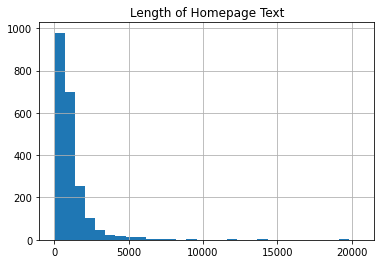

In [11]:
train.len_text.hist(bins=30)
plt.title('Length of Homepage Text')
plt.show()

In [14]:
train.len_text.describe()

count     2164.000000
mean      1128.096580
std       1487.228427
min         14.000000
25%        450.750000
50%        754.000000
75%       1285.000000
max      20489.000000
Name: len_text, dtype: float64

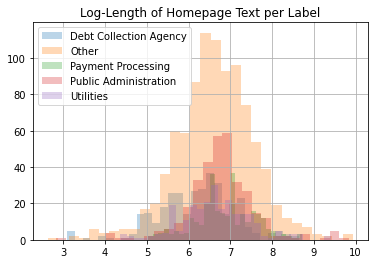

In [18]:
train['log_len_text'] = train.len_text.apply(lambda l: np.log(l))
train.groupby(['label']).log_len_text.hist(bins=30, alpha=0.3, legend=True)
plt.title('Log-Length of Homepage Text per Label')
plt.show()

In [19]:
train.groupby(['label']).log_len_text.describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
Debt Collection Agency,340.0,6.203159,0.926816,3.091042,5.616771,6.289714,6.763008,8.638703
Other,945.0,6.619484,0.948130,2.639057,6.082219,6.630683,7.219642,9.927643
Payment Processing,293.0,6.865234,0.720872,5.030438,6.464588,6.865891,7.388328,8.708805
Public Administration,340.0,6.768930,0.827107,2.833213,6.364320,6.763306,7.140254,9.846229
Utilities,246.0,6.640901,0.836302,4.356709,6.141448,6.605298,7.151485,9.404426


We plot the length of the text to visualize if and we can notice that 
1. the texts are long - the median value of number of words is 750.
2. the distribution is the same for all categories (independant)

### WordCloud Visulization

WordCloud Visualization is a good tool to visualize the most common word in a group of texts.


In [35]:
def wordcloud_visualization(corpus, label):
  wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = STOPWORDS,
                min_font_size = 10).generate(corpus)
 
  # plot the WordCloud image                      
  plt.figure(figsize = (5, 5), facecolor = None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad = 0)
  plt.title('WordCloud For Label: '+label)
  
  plt.show()

def barplot_visualization(corpus, max_features, label):
  tfidf = TfidfVectorizer(ngram_range=(1,3), max_features=max_features, stop_words='english')
  tfidf.fit(corpus)
  X = tfidf.transform(corpus).toarray()
  S = X.sum(axis=0)
  voc = tfidf.get_feature_names_out()
  
  plt.barh(voc, S, align='center')
  plt.xticks(rotation=45)
  plt.title('Vocabulary BarPlot For Label: '+label)
  plt.show()

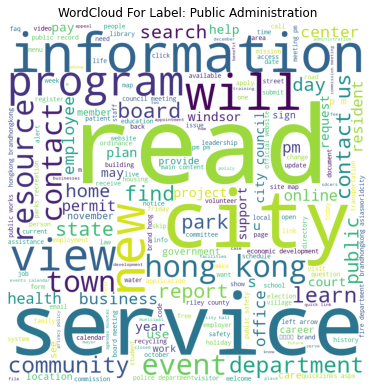

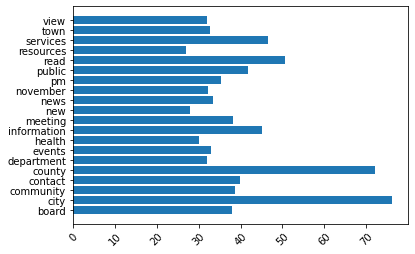

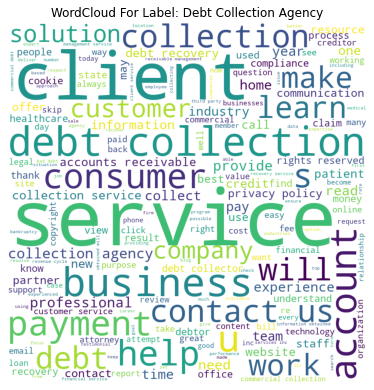

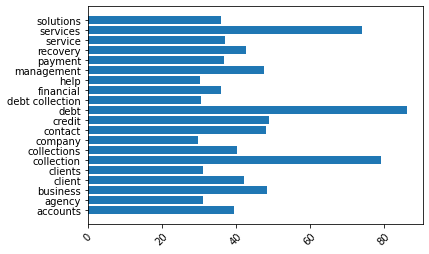

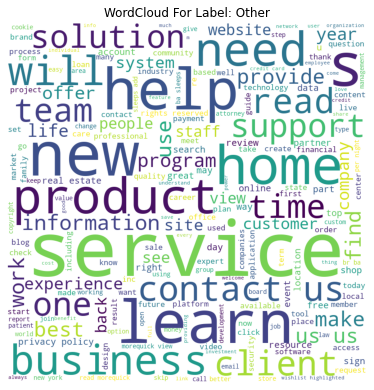

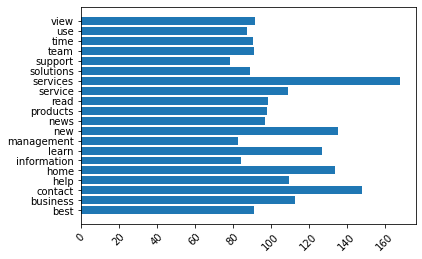

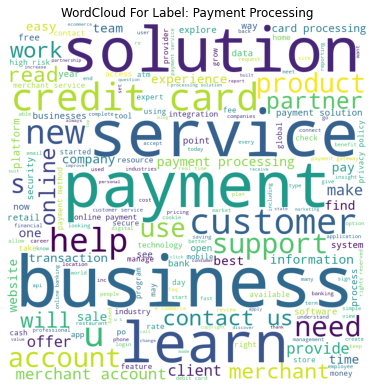

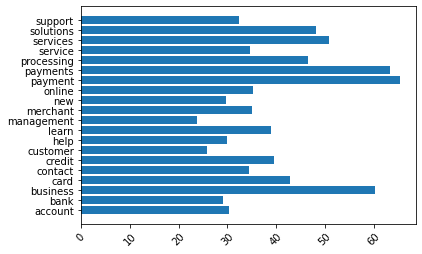

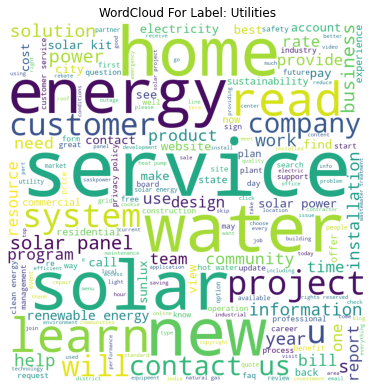

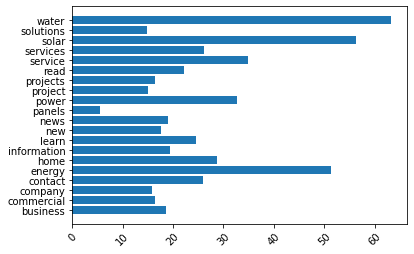

In [37]:
for lbl in train.label.unique():
  corpus = list(map(clean_text, train[train.label==lbl].homepage.tolist()))
  join_corpus = ' '.join(corpus)
  wordcloud_visualization(join_corpus, lbl)
  print()
  barplot_visualization(corpus, 20, lbl)




the WordCloud plots show that it exists an overlapp in the group 's text like the words: service, business, contact.
We need to engineering the text to extract the main part of the text.

### Vocabulary Overlapp - Jaccard Similarity



In [58]:
def Jaccard_Similarity(doc1, doc2): 
    
    # List the unique words in a document
    words_doc1 = set(doc1) 
    words_doc2 = set(doc2)
    
    # Find the intersection of words list of doc1 & doc2
    intersection = words_doc1.intersection(words_doc2)

    # Find the union of words list of doc1 & doc2
    union = words_doc1.union(words_doc2)
        
    # Calculate Jaccard similarity score 
    # using length of intersection set divided by length of union set
    return float(len(intersection)) / len(union)

In [75]:
max_features = 300
J = np.zeros((5,5))
data = []
for i,lbl in enumerate(train.label.unique()):
  # Generate the vocabulary with Tfidf 
  corpus = list(map(clean_text, train[train.label==lbl].homepage.tolist()))
  tfidf = TfidfVectorizer(ngram_range=(1,3), max_features=max_features, stop_words='english')
  tfidf.fit(corpus)
  voc = tfidf.get_feature_names_out()

  data.append(voc)

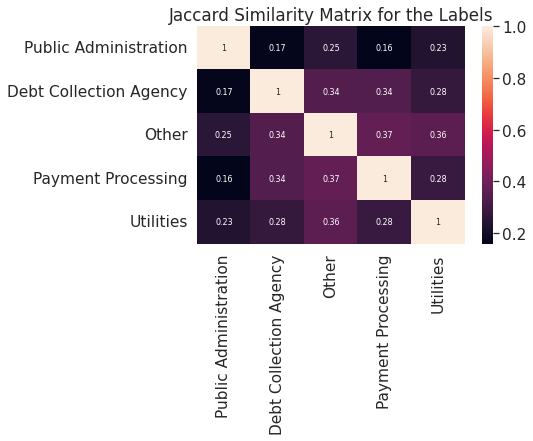

In [77]:
for i in range(5):
  voci = data[i]
  for j in range(5):
    vocj = data[j]

    J[i,j] = Jaccard_Similarity(voci, vocj)

list_class = train.label.unique().tolist()
df_cm = pd.DataFrame(J, list_class, list_class)
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 8}) # font size
plt.title('Jaccard Similarity Matrix for the Labels')
plt.show()

We plot the Jaccard Similarity of the corpus per labels to look for the vocabulary overlapp.
With TfidfVectorizer I extract the 300 most important words per groups.

We observe that the overlapping is significant.

# Text Engineering - Summerization

We want to engineering the text to get the key sentences of each of them.


I go to this direction because my asumption is that text from website (or even from an email) contains a lot of information not relevant due to the label vocabulary overlapping (Jaccard Similarity)


One solution should be find patterns in the text to extract the exact relevant parts based on a rule-based pipline. Due to the many cons on that solution I prefer to use powerful tool like BERT.

## Summerization with BERT

To do so I use BERT and TfidfVectorizer:

1. Generate candidates with TfidfVectorizer
2. Embedd the candidates and the texts with pretrined BERT
3. Use similarity function (cosinus) to select the best best candidates to summerize the text.
4. Create Diversity in key sentences - MMR Maximal Marginal Relevance

The idea behind using MMR is that it tries to reduce redundancy and increase diversity in the result. It selects the final keyphrases list according to a criterion of query relevance and novelty of information. It considers the similarity of keyphrase with the document, along with the similarity of already selected phrases.

In [103]:
def mmr(doc_embedding, word_embeddings, words, top_n, diversity):

    # Extract similarity within words, and between words and the document
    word_doc_similarity = cosine_similarity(word_embeddings, doc_embedding)
    word_similarity = cosine_similarity(word_embeddings)

    # Initialize candidates and already choose best keyword/keyphras
    keywords_idx = [np.argmax(word_doc_similarity)]
    candidates_idx = [i for i in range(len(words)) if i != keywords_idx[0]]

    for _ in range(top_n - 1):
        # Extract similarities within candidates and
        # between candidates and selected keywords/phrases
        candidate_similarities = word_doc_similarity[candidates_idx, :]
        target_similarities = np.max(word_similarity[candidates_idx][:, keywords_idx], axis=1)

        # Calculate MMR
        mmr = (1-diversity) * candidate_similarities - diversity * target_similarities.reshape(-1, 1)
        mmr_idx = candidates_idx[np.argmax(mmr)]

        # Update keywords & candidates
        keywords_idx.append(mmr_idx)
        candidates_idx.remove(mmr_idx)

    return [words[idx] for idx in keywords_idx]


def candidates_extraction(doc):
  count = TfidfVectorizer(ngram_range=(1,3), max_features=50, stop_words='english').fit([doc])
  return count.get_feature_names_out()


def key_sent_extraction(doc, bert_model=bert_model):
  
  # Extract candidates for key sentences
  candidates = candidates_extraction(doc)

  # BERT Embeddings of doc and candidates
  doc_embedding = bert_model.encode(doc).reshape(1,-1)
  candidate_embeddings = bert_model.encode(candidates)

  # Apply MMR to get key sentences
  key_sentences = mmr(doc_embedding, candidate_embeddings, candidates, top_n=10, diversity=0.25)
  
  return ' '.join(key_sentences)

This method has several hyperparameters:
1. ngram_range of tfidf that define the size of the candidates - I set it to (10,20) because I am looking for key sentences if I set it to (1,3) for example I will get a lot of unigram which contains no meaning.
2. max_features that limit the number of candidates in order of importance - i set it to 50 
2. the stopword list - it allow to remove irrelevant words here I set it to None because I want to keep the semantic (or a part of it) 
3. top_n which is the number of key sentences returned - I set to 3
4. diversity factor - it allows to get different key sentences - I set it 0.5

In [104]:
for t in train.sample(n=10).homepage.tolist():
  print()
  print(t.lower().strip())
  print('---------------------------------------------')
  print(key_sent_extraction(clean_text(t)))
  print('---------------------------------------------')
  print()
  print('####################SEPARATOR####################')


home | virginia hospital and healthcare association                     shared services hospac vhha foundation   membersmember login   about vhha   | directory   | virginia hospitals   | contact   | members   |       membersmember login   about vhha   | directory   | virginia hospitals   | contact   | members   |   home advocacy quality & patient safety communications data programs & events resources    search for:     search      search for:     search        the virginia hospital & healthcare association has 25 member health systems, representing 110 community, psychiatric, rehabilitation, and specialty hospitals throughout virginia.    the virginia hospital & healthcare association has 25 member health systems, representing 110 community, psychiatric, rehabilitation, and specialty hospitals throughout virginia.    the virginia hospital & healthcare association has 25 member health systems, representing 110 community, psychiatric, rehabilitation, and specialty hospitals throughout v

In [105]:
train['key_sentence'] = train.homepage.swifter.apply(lambda doc:key_sent_extraction(clean_text(doc)))

Pandas Apply:   0%|          | 0/2164 [00:00<?, ?it/s]

### Length of Summarized Text

In [106]:
train['len_key_sentence'] = train.key_sentence.apply(lambda t:  len(t.split(' ')))

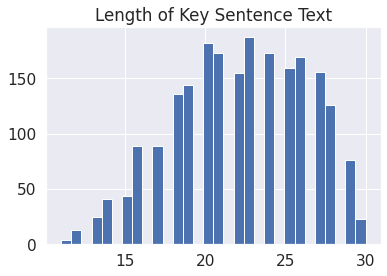

In [107]:
train.len_key_sentence.hist(bins=30)
plt.title('Length of Key Sentence Text')
plt.show()

In [108]:
train.len_key_sentence.describe()

count    2164.000000
mean       22.189926
std         4.133629
min        11.000000
25%        19.000000
50%        22.000000
75%        26.000000
max        30.000000
Name: len_key_sentence, dtype: float64

### WordCloud Visualization

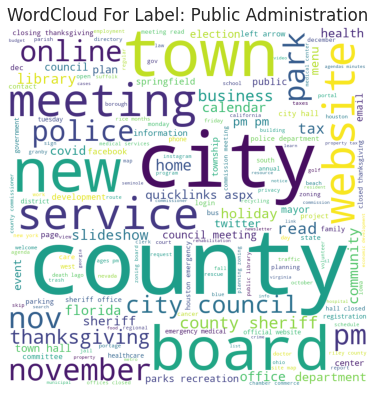

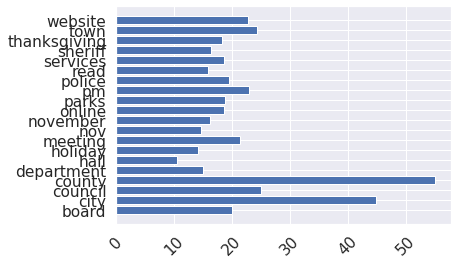

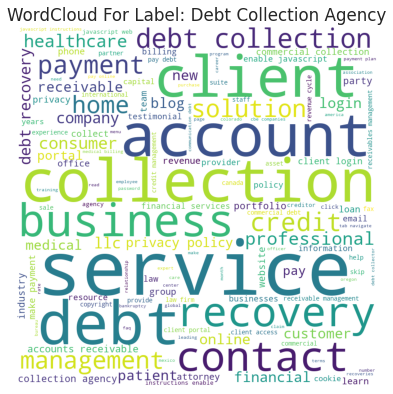

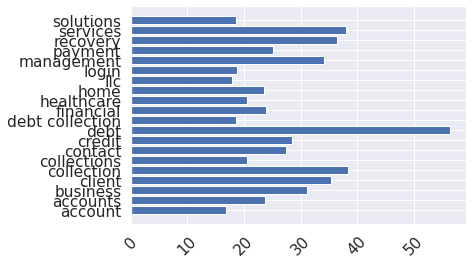

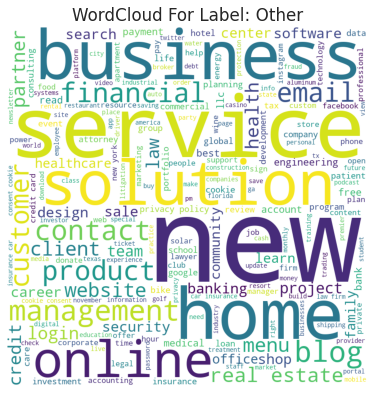

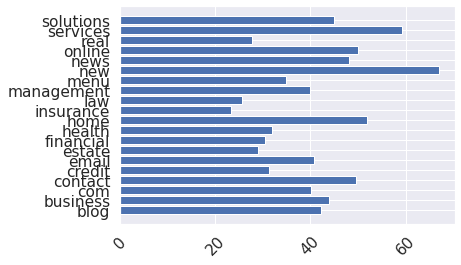

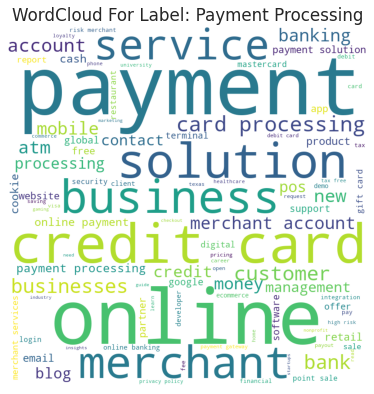

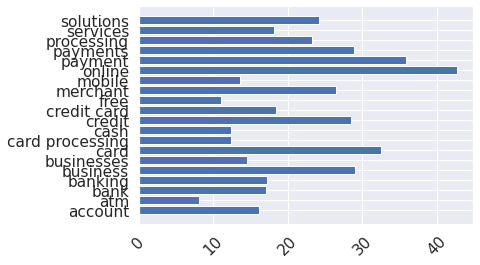

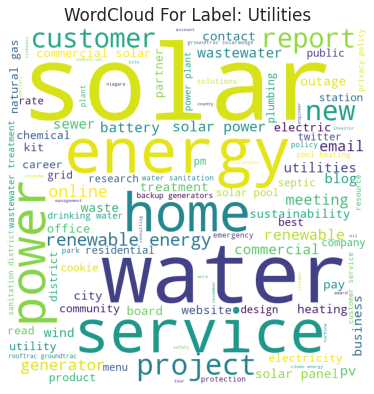

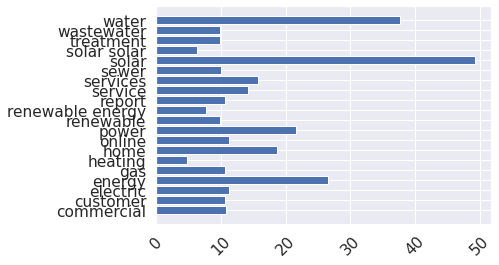

In [109]:
for lbl in train.label.unique():
  corpus = list(map(clean_text, train[train.label==lbl].key_sentence.tolist()))
  join_corpus = ' '.join(corpus)
  wordcloud_visualization(join_corpus, lbl)
  print()
  barplot_visualization(corpus, 20, lbl)

### Vocabulary Overlapp - Jaccard Similarity


In [110]:
max_features = 300
J = np.zeros((5,5))
data = []
for i,lbl in enumerate(train.label.unique()):
  # Generate the vocabulary with Tfidf 
  corpus = list(map(clean_text, train[train.label==lbl].key_sentence.tolist()))
  tfidf = TfidfVectorizer(ngram_range=(1,3), max_features=max_features, stop_words='english')
  tfidf.fit(corpus)
  voc = tfidf.get_feature_names_out()

  data.append(voc)

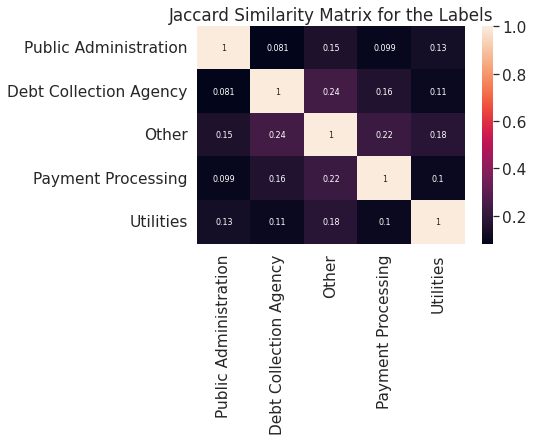

In [111]:
for i in range(5):
  voci = data[i]
  for j in range(5):
    vocj = data[j]

    J[i,j] = Jaccard_Similarity(voci, vocj)

list_class = train.label.unique().tolist()
df_cm = pd.DataFrame(J, list_class, list_class)
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 8}) # font size
plt.title('Jaccard Similarity Matrix for the Labels')
plt.show()

Okay so that is interesting results and it was expected.

The text summerization reduce a lot the overlapping between label's document. It reduces also the length of the texts and keeps the main important features.

However we notice that overlaps with tha category 'Other' are still high.

## Summurization with ChatGPT

In [ ]:
def chatgpt_text_summerization(text):
  # Apply the API key
  openai.api_key = openai_api_key

  # Define the prompt
  text = train.sample(n=1).homepage.values[0]
  prompt = """I want you to summarize in 20 words or less the following text of a website: {}""".format(text[:4000])

  # Generate text using the prompt
  response = openai.Completion.create(
      engine="text-davinci-002",
      prompt=prompt,
      max_tokens=1024,
      n=1,
      stop=None,
  )

  return response["choices"][0]["text"]

In [ ]:
for t in train.sample(n=10).homepage.tolist():
  print()
  print('---------------------------------------------')
  print(chatgpt_text_summerization(t))
  print('---------------------------------------------')
  print()
  print('####################SEPARATOR####################')


---------------------------------------------
Upclick is a custom e-commerce platform with a focus on sales funnel optimization and monetization for digital goods and software products.
---------------------------------------------

####################SEPARATOR####################

---------------------------------------------
4life.io

At Apply 4 Life, we make it easy to compare and select the best life insurance policy for you. With our index of over 80 top providers, we can find the perfect fit for your individual needs.
---------------------------------------------

####################SEPARATOR####################

---------------------------------------------
 						 Visit the Blog

Fiserv is a financial services technology company that serves businesses, merchants, credit unions, banks, large financial institutions, and the public sector.
---------------------------------------------

####################SEPARATOR####################

------------------------------------------

Yes I just try chatGPT and ask it to summarize the text and the results are impressive. 

This is something that can be use in the extraction of data and may be very helpful to perform a better EDA and improve models.

However, because of the API limitation I can t really use it (for now).

# Label Classification

We aim now to predict the label (core's business) of the website from the homepage text. 

In [112]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

from transformers import BertTokenizer, BertModel, BertForSequenceClassification, DistilBertModel, DistilBertTokenizer
import torch
from torch import nn
from torch.optim import Adam
from tqdm import tqdm

In [113]:
# Split the data into train and val
df_train, df_val = train_test_split(train[['key_sentence', 'label', 'homepage']], test_size=0.2, stratify=train.label.values)
df_test = test
print(len(df_train),len(df_val), len(df_test))

# Generate the inputs and outputs for training
corpus_key_sentence = df_train.key_sentence.tolist()
corpus_homepage = list(map(clean_text, df_train.homepage.tolist()))
y = df_train.label.values

# Generate the inputs and outputs for validation
corpus_key_sentence_val = df_val.key_sentence.tolist()
corpus_homepage_val = list(map(clean_text, df_val.homepage.tolist()))
y_val = df_val.label.values

# Generate the inputs and outputs for test
corpus_homepage_test = list(map(clean_text, df_test.homepage.tolist()))
y = df_train.label.values


1731 433 1293


## Fine Tunning BERT

In [ ]:
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# labels = {'Other':0,
#           'Public Administration':1,
#           'Debt Collection Agency':2,
#           'Payment Processing':3,
#           'Utilities':4
#           }


# class Dataset(torch.utils.data.Dataset):

#     def __init__(self, df):

#         self.labels = [labels[label] for label in df['label']]
#         self.texts = [tokenizer(text, 
#                                 padding='max_length', 
#                                 max_length = 512, 
#                                 truncation=True,
#                                 return_tensors="pt") for text in df['key_sentence']]

#     def classes(self):
#         return self.labels

#     def __len__(self):
#         return len(self.labels)

#     def get_batch_labels(self, idx):
#         # Fetch a batch of labels
#         return np.array(self.labels[idx])

#     def get_batch_texts(self, idx):
#         # Fetch a batch of inputs
#         return self.texts[idx]

#     def __getitem__(self, idx):

#         batch_texts = self.get_batch_texts(idx)
#         batch_y = self.get_batch_labels(idx)

#         return batch_texts, batch_y


# class BertClassifier(nn.Module):

#     def __init__(self, dropout=0.5):

#         super(BertClassifier, self).__init__()

#         self.bert = BertModel.from_pretrained('bert-base-uncased')
#         self.dropout = nn.Dropout(dropout)
#         self.linear = nn.Linear(768, 5)
#         self.relu = nn.ReLU()

#     def forward(self, input_id, mask):

#         _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
#         dropout_output = self.dropout(pooled_output)
#         linear_output = self.linear(dropout_output)
#         final_layer = self.relu(linear_output)

#         return final_layer


# def train_model(model, train_data, val_data, learning_rate, batch, epochs):

#     train, val = Dataset(train_data), Dataset(val_data)

#     train_dataloader = torch.utils.data.DataLoader(train, batch_size=batch, shuffle=True)
#     val_dataloader = torch.utils.data.DataLoader(val, batch_size=batch)

#     use_cuda = False 
#     device = torch.device("cuda" if use_cuda else "cpu")

#     criterion = nn.CrossEntropyLoss()
#     optimizer = Adam(model.parameters(), lr= learning_rate)

#     if use_cuda:

#             model = model.cuda()
#             criterion = criterion.cuda()

#     for epoch_num in range(epochs):

#             total_acc_train = 0
#             total_loss_train = 0

#             for train_input, train_label in tqdm(train_dataloader):

#                 train_label = train_label.to(device)
#                 mask = train_input['attention_mask'].to(device)
#                 input_id = train_input['input_ids'].squeeze(1).to(device)

#                 output = model(input_id, mask)
                
#                 batch_loss = criterion(output, train_label.long())
#                 total_loss_train += batch_loss.item()
                
#                 acc = (output.argmax(dim=1) == train_label).sum().item()
#                 total_acc_train += acc

#                 model.zero_grad()
#                 batch_loss.backward()
#                 optimizer.step()
            
#             total_acc_val = 0
#             total_loss_val = 0

#             with torch.no_grad():

#                 for val_input, val_label in val_dataloader:

#                     val_label = val_label.to(device)
#                     mask = val_input['attention_mask'].to(device)
#                     input_id = val_input['input_ids'].squeeze(1).to(device)

#                     output = model(input_id, mask)

#                     batch_loss = criterion(output, val_label.long())
#                     total_loss_val += batch_loss.item()
                    
#                     acc = (output.argmax(dim=1) == val_label).sum().item()
#                     total_acc_val += acc
            
#             print(
#                 f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
#                 | Train Accuracy: {total_acc_train / len(train_data): .3f} \
#                 | Val Loss: {total_loss_val / len(val_data): .3f} \
#                 | Val Accuracy: {total_acc_val / len(val_data): .3f}')
            

# def evaluate(model, test_data, batch):

#     test = Dataset(test_data)

#     test_dataloader = torch.utils.data.DataLoader(test, batch_size=batch)

#     use_cuda = torch.cuda.is_available()
#     device = torch.device("cuda" if use_cuda else "cpu")

#     if use_cuda:

#         model = model.cuda()

#     total_acc_test = 0
#     with torch.no_grad():

#         for test_input, test_label in test_dataloader:

#               test_label = test_label.to(device)
#               mask = test_input['attention_mask'].to(device)
#               input_id = test_input['input_ids'].squeeze(1).to(device)

#               output = model(input_id, mask)

#               acc = (output.argmax(dim=1) == test_label).sum().item()
#               total_acc_test += acc
    
#     print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')



# EPOCHS = 5
# batch = 5
# model = BertClassifier()
# LR = 1e-6
              
# train_model(model, df_train, df_val, LR, batch, EPOCHS)

# evaluate(model, df_test, batch)

I try to fintune BERT with Pytorch to obtain a powerful model. However the runnig time was very long and when I try to manage the memory I ve got several errors that require time to solve that I do not have. (I thought it will run easily on the free access gpu of colab)

## From Sparse Matrix - RandomForest

That is a direct solution that require not a lot of effort to try.
Moreover, RandomForest is a good candidate form imbalanced datasets.

The tfidf model will first embedd the documents and exract a vocabulary taht becomes the features. Then RandomForest trains on these features.

We apply this pipeline on the key sentences data and the initial homepage data to see the difference. I assume that the key sentences reach better performance due to the removal of irrelevant text.

To ease the developement and find the best model, I use a randomized GridSearch CV on a Pipeline model.

The tools form sklearn (Pipeline and RandomizedSearchCV) allow to create a straight forward pipeline.

Notice here that because of the imbalanced of the data I set the scoring of the randomized grid search on the f1 score which is more suitable.



In [126]:
def plot_cm(clf, y, yp):
    cm = confusion_matrix(y, yp, normalize=None)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(cm, list(clf.classes_), list(clf.classes_))
    # plt.figure(figsize=(10,7))
    sns.set(font_scale=1.4) # for label size
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 8}) # font size

    plt.show()




### on Key Sentences

                        precision    recall  f1-score   support

Debt Collection Agency       0.74      0.85      0.79        68
                 Other       0.79      0.69      0.73       189
    Payment Processing       0.62      0.76      0.68        59
 Public Administration       0.84      0.79      0.82        68
             Utilities       0.70      0.76      0.73        49

              accuracy                           0.75       433
             macro avg       0.74      0.77      0.75       433
          weighted avg       0.76      0.75      0.75       433



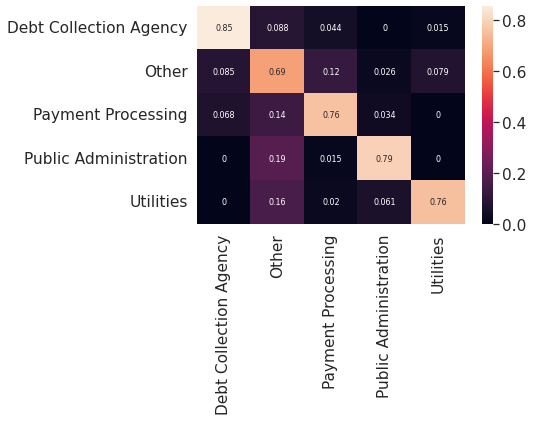

In [119]:
steps = [('tfidf', TfidfVectorizer()), ('rf', RandomForestClassifier())]
          
parameters  = {
    'tfidf__ngram_range': [(1,3)],
    'tfidf__max_df': [0.9, 0.95],
    'tfidf__min_df': [0.01, 0.005, 0.001, 0.0005],
    'tfidf__stop_words': ['english', None],
    'rf__n_estimators': [5,20,50,100],
    'rf__max_features': ['auto', 'sqrt'],
    'rf__max_depth': [int(x) for x in np.linspace(10, 120, num=12)],
    'rf__min_samples_split': [2, 6, 10],
    'rf__min_samples_leaf': [1, 3, 4],
    'rf__class_weight':['balanced'],
    'rf__bootstrap': [True, False]}

clf = Pipeline(steps)
clf_random = RandomizedSearchCV(estimator=clf,
                               param_distributions=parameters,
                               n_iter=15, 
                               cv=5, 
                               verbose=0, 
                               random_state=17,
                                scoring='f1_macro')

clf_random.fit(corpus_key_sentence, y)

clf = clf_random.best_estimator_

y_pred = clf.predict(corpus_key_sentence_val)

print(classification_report(y_val, y_pred))

plot_cm(clf, y_val, y_pred)

The pipeline Tfidf+RandomForest gives relatively good results on the key sentences exctracted.

1. The main problem is the model predict too much 'Other' the rest of the classes. It has a lack of precision for the class 'Other'- by looking the the columns 'Other'.
2. The classes 'Utilities' and 'Payment Processing' have a lower f1 score.

The category 'Other' is the one cuasing the most of troubles. In fact, it reflects the Jaccard Similarity results - overlapping of vocabulary.


### On Homepage Text

                        precision    recall  f1-score   support

Debt Collection Agency       0.94      0.85      0.89        68
                 Other       0.82      0.90      0.86       189
    Payment Processing       0.81      0.80      0.80        59
 Public Administration       0.88      0.85      0.87        68
             Utilities       0.82      0.67      0.74        49

              accuracy                           0.85       433
             macro avg       0.85      0.82      0.83       433
          weighted avg       0.85      0.85      0.84       433



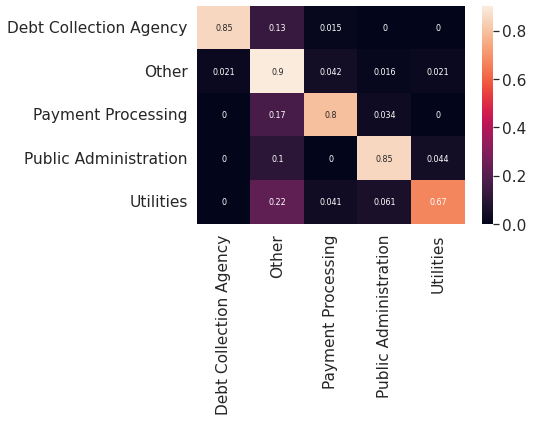

In [120]:
steps = [('tfidf', TfidfVectorizer()), ('rf', RandomForestClassifier())]
          
parameters  = {
    'tfidf__ngram_range': [(1,3)],
    'tfidf__max_df': [ 0.95],
    'tfidf__min_df': [0.01, 0.005],
    'tfidf__stop_words': ['english', None],
    'rf__n_estimators': [5,20,50,100],
    'rf__max_features': ['auto', 'sqrt'],
    'rf__max_depth': [int(x) for x in np.linspace(10, 120, num=5)],
    'rf__min_samples_split': [2, 6, 10],
    'rf__min_samples_leaf': [1, 3, 4],
    'rf__class_weight':['balanced'],
    'rf__bootstrap': [True, False]}

clf = Pipeline(steps)
clf_random = RandomizedSearchCV(estimator=clf,
                               param_distributions=parameters,
                               n_iter=2, 
                               cv=5, 
                               verbose=0, 
                               random_state=15,
                                scoring='f1_macro')

clf_random.fit(corpus_homepage, y)

clf = clf_random.best_estimator_

y_pred = clf.predict(corpus_homepage_val)

print(classification_report(y_val, y_pred))

plot_cm(clf, y_val, y_pred)

Running the same process on the initial data gives better accuracy with a gain of 10 points !!
Also the f1 scores are higher.

Okay so, the BERT summarization does not working as expected althought the EDA shown that it reduce the lenght of the text by keeping the important features.

The problem may come from the frequentist view I took. I mean that, the method used assumes that more a word is important more it is redundant in the data. However it looks like this assumption can not be taken on homepage text.
Why?? Need more time to dig.

With the inital homepage data, the recall and the precision improved even if the model lack of precision for the ctegory 'Other' still

In [128]:
df_test['prediction_hp'] = clf.predict(corpus_homepage_test)

In [129]:
df_test.prediction_hp.value_counts(normalize=True)

Other                     0.608662
Public Administration     0.110596
Debt Collection Agency    0.103635
Payment Processing        0.092807
Utilities                 0.084300
Name: prediction_hp, dtype: float64

So we obtain on the test set a different distribution of labels. We see clearly that the model is biased on the category 'Other'.

## Biais Model

We notice that the model is biais towards the category 'Other'.

The first reason is because the dataset is imbalanced and we can perform an undersampling  on the category 'Other' to adjust the dataset.

I use a random undersampling (but other methods exists) just to see the effects on the model biais.

In [149]:
under_train = df_train.drop(df_train[df_train.label=='Other'].sample(n=600).index)

In [150]:
under_train.label.value_counts(normalize=True)

Public Administration     0.240495
Debt Collection Agency    0.240495
Payment Processing        0.206897
Utilities                 0.174182
Other                     0.137931
Name: label, dtype: float64

In [151]:
under_corpus_homepage = list(map(clean_text, under_train.homepage.tolist()))
under_y = under_train.label.values

                        precision    recall  f1-score   support

Debt Collection Agency       0.82      0.90      0.86        68
                 Other       0.84      0.65      0.73       189
    Payment Processing       0.66      0.83      0.74        59
 Public Administration       0.79      0.91      0.85        68
             Utilities       0.68      0.84      0.75        49

              accuracy                           0.78       433
             macro avg       0.76      0.83      0.79       433
          weighted avg       0.79      0.78      0.77       433



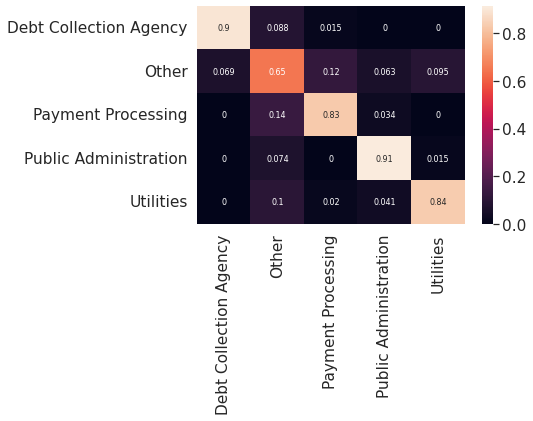

In [146]:
clf = Pipeline(steps)
clf_random = RandomizedSearchCV(estimator=clf,
                               param_distributions=parameters,
                               n_iter=5, 
                               cv=5, 
                               verbose=0, 
                               random_state=15,
                                scoring='accuracy')

clf_random.fit(under_corpus_homepage, under_y)

clf = clf_random.best_estimator_

y_pred = clf.predict(corpus_homepage_val)

print(classification_report(y_val, y_pred))

plot_cm(clf, y_val, y_pred)

The confusion matrix shows better results on its diagonal, espescialy for the category 'Utilities'.

However we can notice a change of behavior. The model gained in precision for the category 'Other' but loose recall for the rest of the categories.  

The random undersampling may not be an interesting methodolgy because we have no control on shom we remove. 

In [147]:
test['prediction'] = clf.predict(corpus_homepage_test)

In [148]:
test.prediction.value_counts(normalize=True)

Other                     0.418407
Debt Collection Agency    0.151585
Public Administration     0.150812
Payment Processing        0.143852
Utilities                 0.135344
Name: prediction, dtype: float64

In [154]:
test[['DOMAIN', 'homepage', 'prediction']].to_csv('/content/drive/MyDrive/AtBayHS/df_test_results.csv')

We reduce the biais due to the imbalanced however the undersampling tecnique used does not take into consideration the overlapp of vocabulary. This is another direction we can take to improve the data.

# Conclusion

I start by making an EDA on the website' s domain and I discover that there is a relation about the quality of the top level domain and the distribution of the label.
However I decided to not use this information for only focused on the homepage text and realize the classification model.

The EDA on the homepage text shown that the different corpuses (per label) share common words which creates overlaps in their vocabulary.
The cause can come from the length of the texts and the repition of irrelevant words.

To face this issue i decided to build a text summarizer based on SenetenceBERT pretrained model and TfidfVectorizer.
I applied the same results and conclude about diminution of the length of the texts by keeping relevant words.

Then I build a model to clasify the core business of a website according to its homepage text.
I wanted to finetune BERT using Pytorch framework, however I face running time issue and memory access due to the limitations of colab GPU.
So I decided to use a common pipeline Tfidf+RandomForest, which give "correct" results (interesting to debate about recall precision in which direction we can improve such a model).

On the summarized, the results are not so great so I train it in the same way on the inital data and i get better results. Summerization with BERT is not so helpfull in that case. I think it is due to the semantic/linguistic of a homepage website text.

For now I used only the homepage text for training.

I notice that the model is bias due to the exgerate representation of the category 'Other', to reduce this biais in our context, a straight forward solution will be to under sample the category 'Other'. It get results better results but the model looses its capability to predict 'Other' like before. I think yjis is due to the overlaps in the data which the model is too sensible.



Ps: the instructions say category 'Other' represents the legitimate core business and the rest of them are denoted as restricted. I think it should be the oppposite. Or do you considare that Utilities, Payment Processing, Public Administration and Debt Collection Agency should not have any cybersecurity insurance? Are not legitimate ?